In [1]:
import os
import os.path as osp
import time

import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from simple_plot3d import Canvas_3D, Canvas_BEV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load Sample KITTI Data

In [2]:
# Load Calib
def _extend_matrix(mat):
    mat = np.concatenate([mat, np.array([[0., 0., 0., 1.]])], axis=0)
    return mat

calib_lines = open("demo/data/000008_calib.txt", 'r').readlines()

P2 = _extend_matrix(np.array([float(info) for info in calib_lines[2].split(' ')[1:13]]).reshape([3, 4]))
Tr_velo_to_cam = _extend_matrix(np.array([float(info) for info in calib_lines[5].split(' ')[1:13]]).reshape([3, 4]))
R0_rect = np.array([float(info) for info in calib_lines[4].split(' ')[1:10]]).reshape([3, 3])
rect_4x4 = np.zeros([4, 4], dtype=R0_rect.dtype)
rect_4x4[3, 3] = 1.
rect_4x4[:3, :3] = R0_rect
R0_rect = rect_4x4

# Load Labels
label_lines = open("demo/data/000008_label_2.txt", 'r').readlines()
label_lines = [line.strip().split(' ') for line in label_lines]
gt_names = np.array([x[0] for x in label_lines])
gt_dims = np.array([[float(info) for info in x[8:11]] for x in label_lines]).reshape(-1, 3)[:, [2, 0, 1]]
gt_locs = np.array([[float(info) for info in x[11:14]] for x in label_lines]).reshape(-1, 3)
gt_rots = np.array([float(x[14]) for x in label_lines]).reshape(-1)
gt_bboxes_3d = np.concatenate([gt_locs, gt_dims, gt_rots[..., np.newaxis]], axis=1).astype(np.float32)

care_mask = gt_names != 'DontCare'
gt_names = gt_names[care_mask]
gt_bboxes_3d = gt_bboxes_3d[care_mask]

# Load Image
img = cv2.imread("demo/data/000008_image_2.png")[..., ::-1] # BGR to RGB

# Load Point Cloud
pts_xyz = np.fromfile("demo/data/000008_velodyne.bin", dtype=np.float32).reshape(-1, 4)[:, :3] # drop reflectance

## Convert KITTI 3D Boxes from Camera to LiDAR Coordinates

In [3]:
gt_lidar_dims = np.concatenate([gt_bboxes_3d[:, [5]], gt_bboxes_3d[:, [3]], gt_bboxes_3d[:, [4]]], axis=1)
gt_locs_hom = np.concatenate([gt_bboxes_3d[:, :3], np.ones((gt_bboxes_3d.shape[0], 1))], axis=1)
gt_lidar_locs = gt_locs_hom @ np.linalg.inv(Tr_velo_to_cam.T) @ np.linalg.inv(R0_rect.T)
gt_lidar_bboxes_3d = np.concatenate([gt_lidar_locs[:, :3], gt_lidar_dims, gt_bboxes_3d[:, [6]]], axis=1)

## Get RGB values for points visible from Image

In [4]:
pts_hom = np.concatenate([pts_xyz, np.ones((len(pts_xyz), 1))], axis=1)
pts_img = pts_hom @ Tr_velo_to_cam.T @ R0_rect.T @ P2.T

pts_img[:, 0] /= pts_img[:, 2]
pts_img[:, 1] /= pts_img[:, 2]

pts_img = pts_img.round().astype(np.int32)

in_image_mask = ((pts_img[:, 2] > 0.1) &
                 (pts_img[:, 0] > 0) & (pts_img[:, 0] < img.shape[1]) &
                 (pts_img[:, 1] > 0) & (pts_img[:, 1] < img.shape[0]))

pts_xyz_img = pts_xyz[in_image_mask]
pts_img = pts_img[in_image_mask]
pts_rgb = img[pts_img[:, 1], pts_img[:, 0]]

# Visualize BEV

## Barebones Visualization

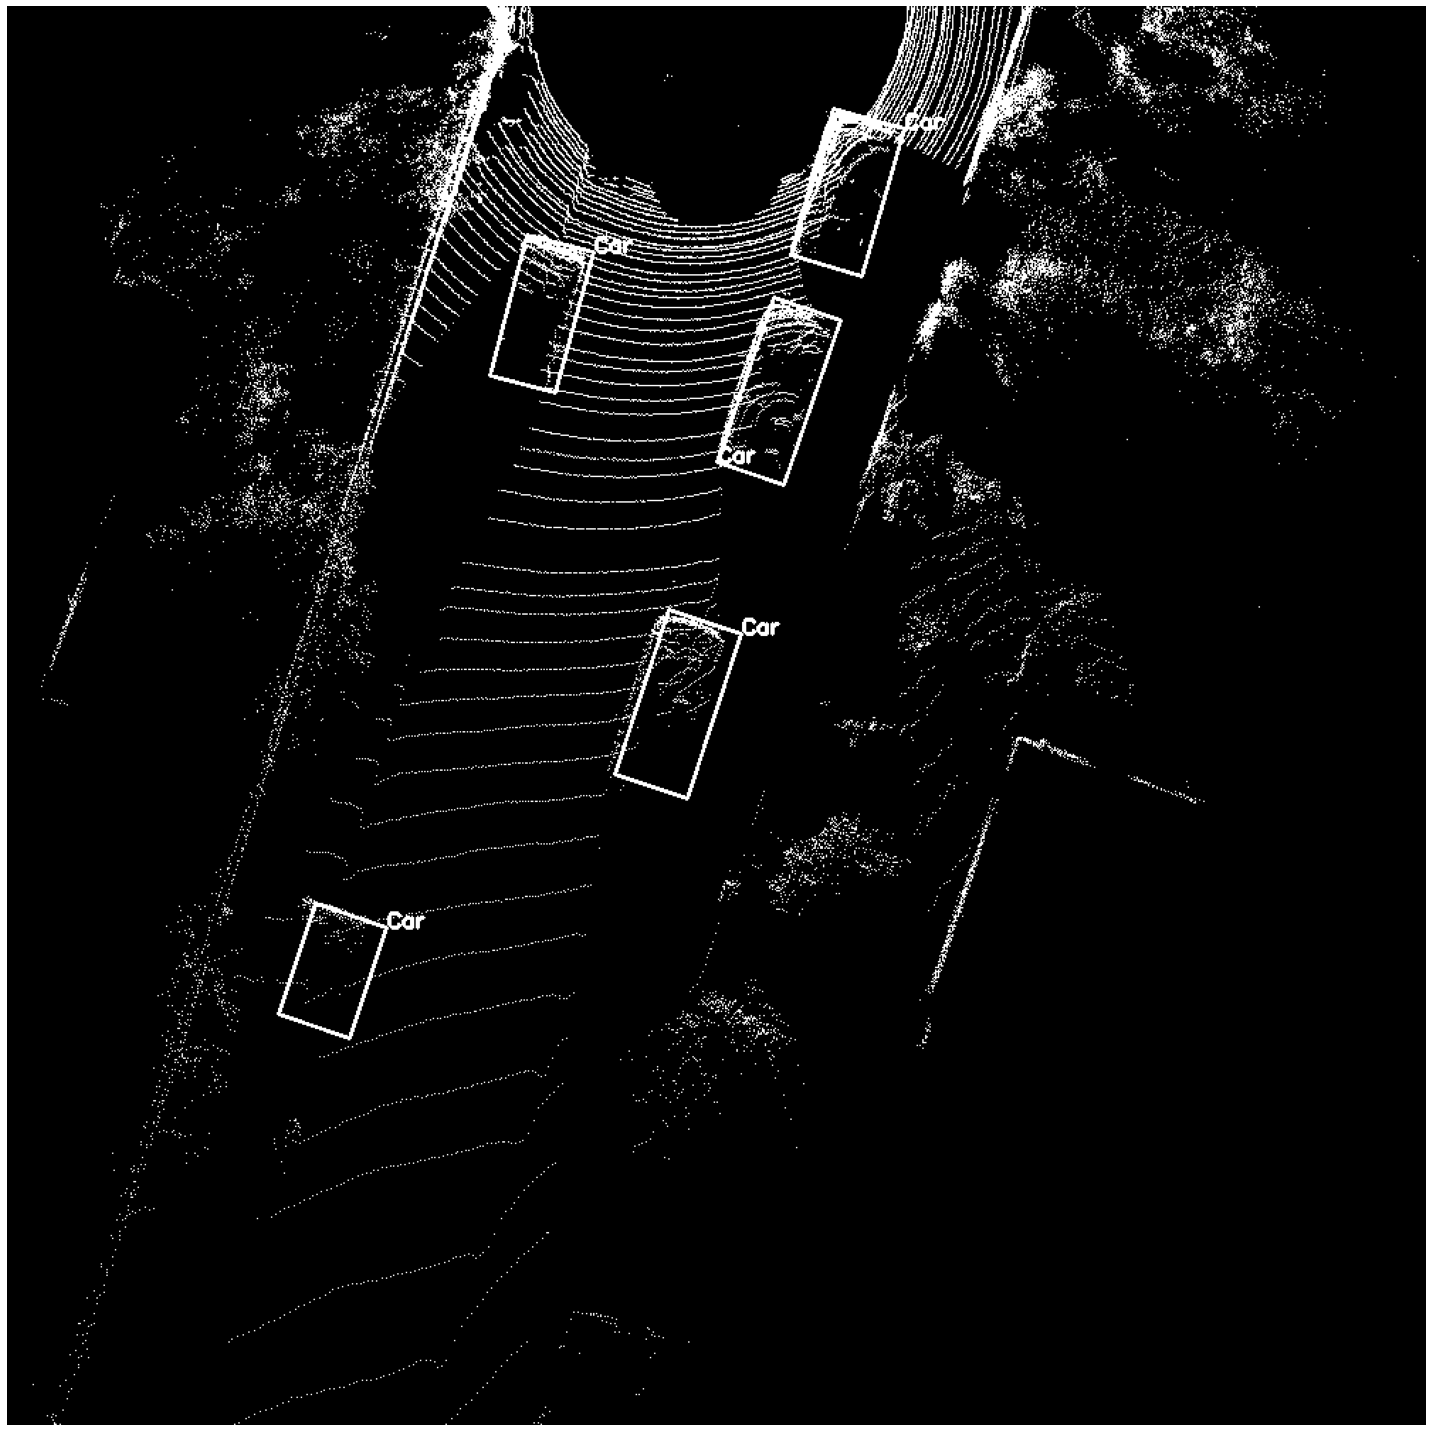

In [5]:
canvas_bev = Canvas_BEV(canvas_shape=(1000, 1000),
                        canvas_x_range=(0, 30),
                        canvas_y_range=(-15, 15))

canvas_xy, valid_mask = canvas_bev.get_canvas_coords(pts_xyz) # Get Canvas Coords
canvas_bev.draw_canvas_points(canvas_xy[valid_mask]) # Only draw valid points
canvas_bev.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names) # Draw Boxes

plt.figure(figsize=(20, 20)); plt.axis('off')
plt.imshow(canvas_bev.canvas)

plt.tight_layout()
plt.savefig("demo/canvas_bev_barebones.png", transparent=False)

## Various Colors

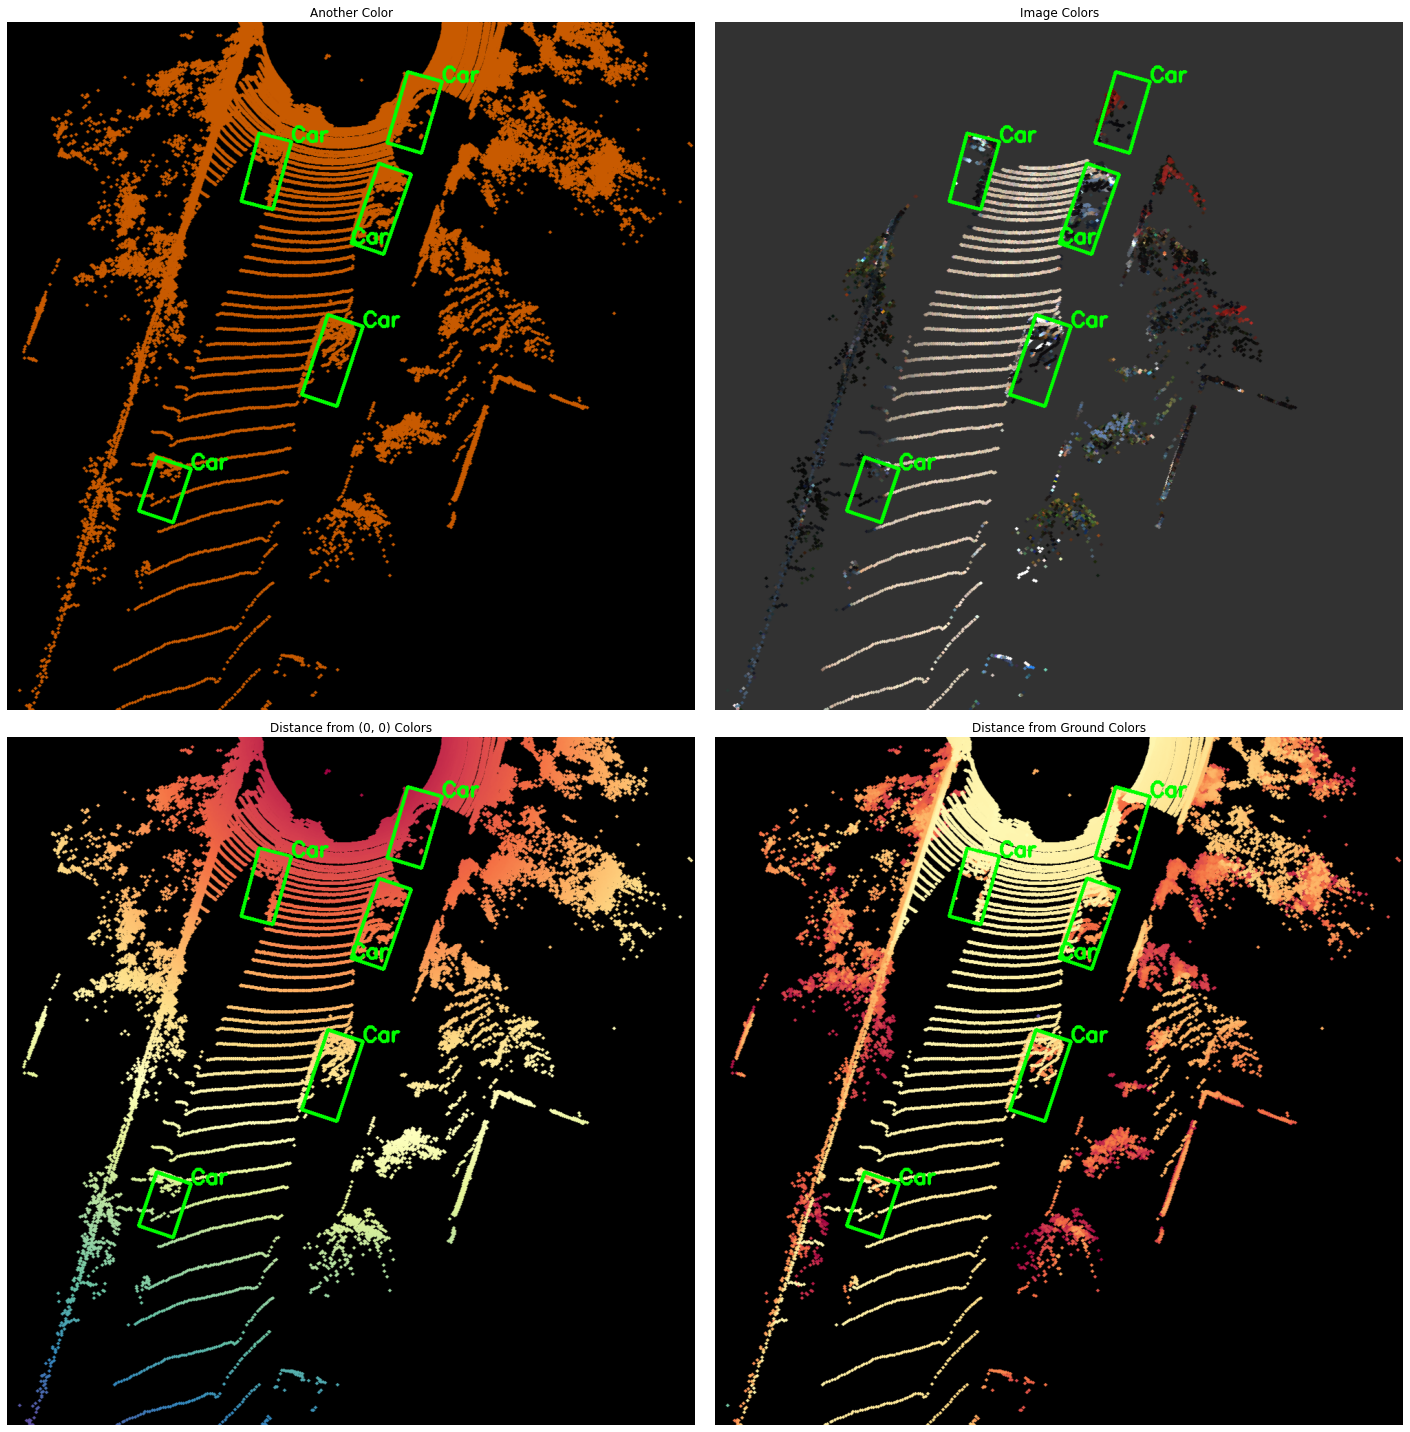

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0, 0].set_title("Another Color")
canvas_bev = Canvas_BEV(canvas_shape=(1000, 1000), canvas_x_range=(0, 30), canvas_y_range=(-15, 15))
canvas_xy, valid_mask = canvas_bev.get_canvas_coords(pts_xyz)
canvas_bev.draw_canvas_points(canvas_xy[valid_mask], colors=(200, 90, 0), radius=2)
canvas_bev.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[0, 0].imshow(canvas_bev.canvas)
axes[0, 0].axis('off')

# Note: the "smearing" of red on the side is because lidar is above the camera,
# causing points captured behind the red car to be projected onto the red car
axes[0, 1].set_title("Image Colors")
canvas_bev = Canvas_BEV(canvas_shape=(1000, 1000), canvas_x_range=(0, 30), canvas_y_range=(-15, 15), canvas_bg_color=(50, 50, 50))
canvas_xy, valid_mask = canvas_bev.get_canvas_coords(pts_xyz_img)
canvas_bev.draw_canvas_points(canvas_xy[valid_mask], colors=pts_rgb[valid_mask], radius=2)
canvas_bev.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[0, 1].imshow(canvas_bev.canvas)
axes[0, 1].axis('off')

axes[1, 0].set_title("Distance from (0, 0) Colors")
canvas_bev = Canvas_BEV(canvas_shape=(1000, 1000), canvas_x_range=(0, 30), canvas_y_range=(-15, 15))
canvas_xy, valid_mask = canvas_bev.get_canvas_coords(pts_xyz)
canvas_bev.draw_canvas_points(canvas_xy[valid_mask], colors='Spectral', radius=2)
canvas_bev.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[1, 0].imshow(canvas_bev.canvas)
axes[1, 0].axis('off')

axes[1, 1].set_title("Distance from Ground Colors")
canvas_bev = Canvas_BEV(canvas_shape=(1000, 1000), canvas_x_range=(0, 30), canvas_y_range=(-15, 15))
canvas_xy, valid_mask = canvas_bev.get_canvas_coords(pts_xyz)
# Here, you can make colors_operand positive or negative to flip the cmap as you want
canvas_bev.draw_canvas_points(canvas_xy[valid_mask], colors='Spectral', colors_operand=-pts_xyz[:, 2][valid_mask], radius=2)
canvas_bev.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[1, 1].imshow(canvas_bev.canvas)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig("demo/canvas_bev_various_colors.png", transparent=False)

# Visualize 3D

# Barebones Visualization

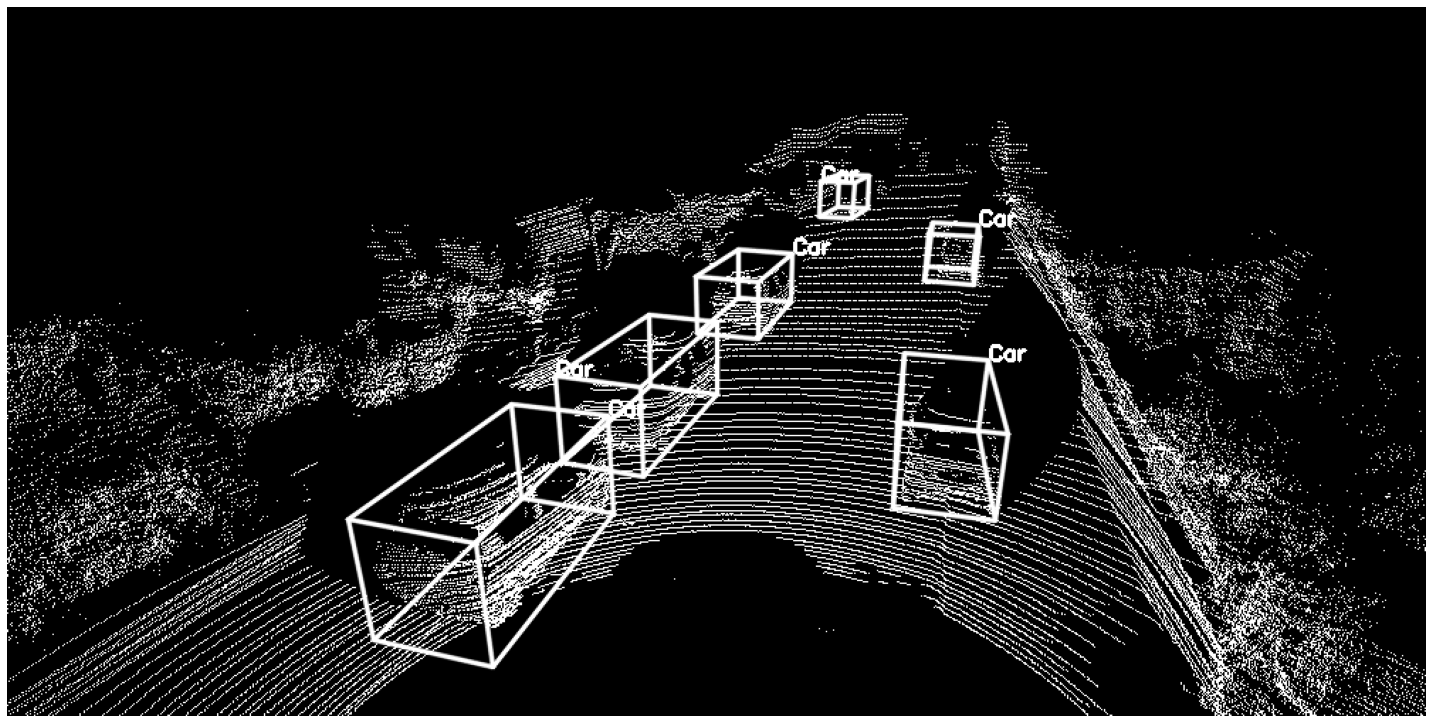

In [7]:
canvas_bev = Canvas_3D()

canvas_xy, valid_mask = canvas_bev.get_canvas_coords(pts_xyz)
canvas_bev.draw_canvas_points(canvas_xy[valid_mask])
canvas_bev.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names)

plt.figure(figsize=(20, 20)); plt.axis('off')
plt.imshow(canvas_bev.canvas)

plt.tight_layout()
plt.savefig("demo/canvas_3d_barebones.png", transparent=False)

# Various Colors

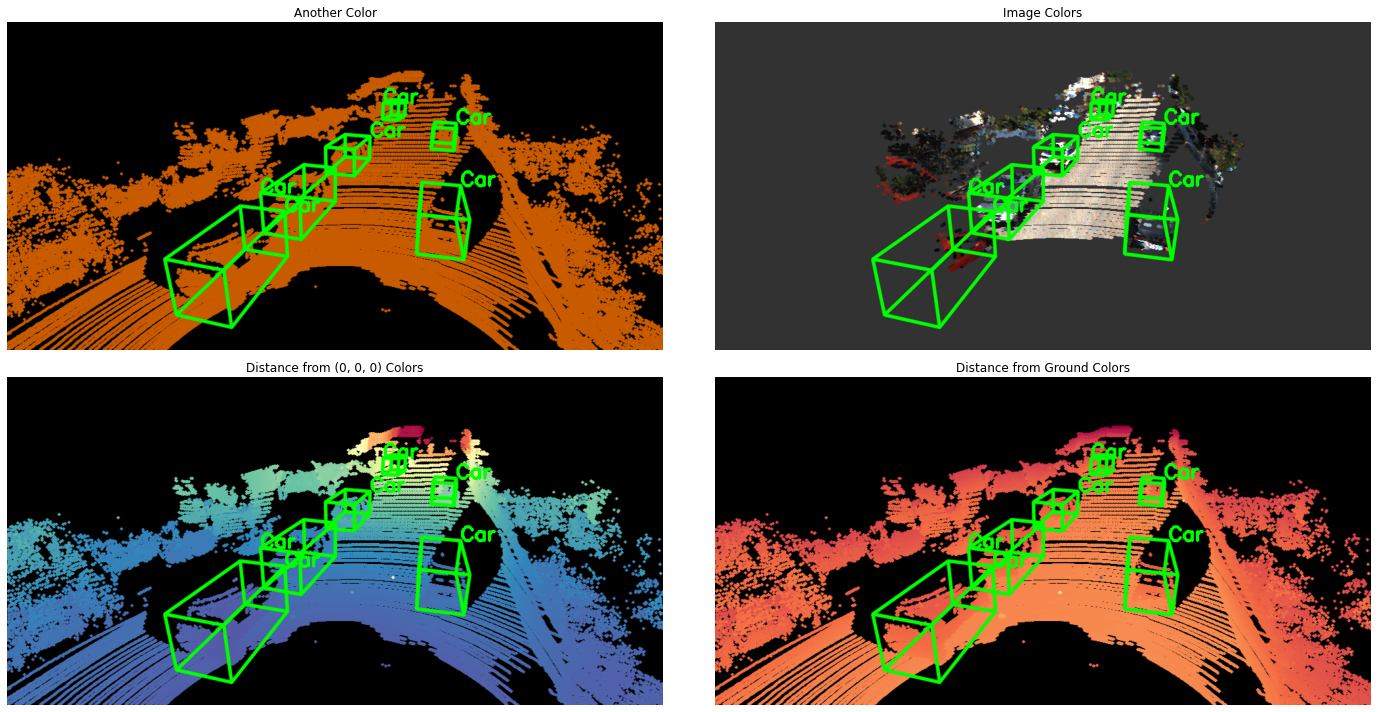

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title("Another Color")
canvas_3d = Canvas_3D()
canvas_xy, valid_mask = canvas_3d.get_canvas_coords(pts_xyz)
canvas_3d.draw_canvas_points(canvas_xy[valid_mask], colors=(200, 90, 0), radius=2)
canvas_3d.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[0, 0].imshow(canvas_3d.canvas)
axes[0, 0].axis('off')

# Note: the "smearing" of red on the side is because lidar is above the camera,
# causing points captured behind the red car to be projected onto the red car
axes[0, 1].set_title("Image Colors")
canvas_3d = Canvas_3D(canvas_bg_color=(50, 50, 50))
canvas_xy, valid_mask = canvas_3d.get_canvas_coords(pts_xyz_img)
canvas_3d.draw_canvas_points(canvas_xy[valid_mask], colors=pts_rgb[valid_mask], radius=2)
canvas_3d.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[0, 1].imshow(canvas_3d.canvas)
axes[0, 1].axis('off')

axes[1, 0].set_title("Distance from (0, 0, 0) Colors")
canvas_3d = Canvas_3D()
canvas_xy, valid_mask = canvas_3d.get_canvas_coords(pts_xyz)
canvas_3d.draw_canvas_points(canvas_xy[valid_mask], colors='Spectral', colors_operand=-np.linalg.norm(pts_xyz[valid_mask], axis=1), radius=2)
canvas_3d.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[1, 0].imshow(canvas_3d.canvas)
axes[1, 0].axis('off')

axes[1, 1].set_title("Distance from Ground Colors")
canvas_3d = Canvas_3D()
canvas_xy, valid_mask = canvas_3d.get_canvas_coords(pts_xyz)
canvas_3d.draw_canvas_points(canvas_xy[valid_mask], colors='Spectral', colors_operand=-pts_xyz[:, 2][valid_mask], radius=2)
canvas_3d.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=3, box_text_size=1)
axes[1, 1].imshow(canvas_3d.canvas)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig("demo/canvas_3d_various_colors.png", transparent=False)

## Moving Camera Use Case

In [9]:
def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

def view_sph_to_cart(az, el):
    x, y, z = sph2cart(az, el, 1)
    return x, y, z

def get_flight_path(num_frames=100, start_camera_loc=[-4, 0, 4], end_camera_loc=[60, 0, 4]):
    start_camera_loc = np.array(start_camera_loc)
    end_camera_loc = np.array(end_camera_loc)
    
    num_sweeps = 2
    max_sweep_viewing_az = np.pi / 12 # 15 degrees
    fixed_el = -np.pi / 9 # -20 deg
    
    # Get list of all camera centers and camera focuses
    normalized_timesteps = np.arange(num_frames) / num_frames
    camera_centers = ((end_camera_loc - start_camera_loc) * normalized_timesteps[:, None]) + start_camera_loc # N x 3
    
    # For sweeps, going to use sin function.
    sweep_sample_locations_target = np.linspace(0, num_sweeps * (2 * np.pi), num_frames)
    
    sweep_sample_interpolate = np.linspace(0, num_sweeps * (2 * np.pi), 4 * num_sweeps + 1)
    locations_to_interpolate_between = np.sin(sweep_sample_interpolate)
    
    sweep_norm_angles = np.interp(sweep_sample_locations_target, sweep_sample_interpolate, locations_to_interpolate_between)
    
    sweep_az_angles = max_sweep_viewing_az * sweep_norm_angles
    camera_focus_relative_cart = np.stack([*view_sph_to_cart(
        sweep_az_angles,
        np.full_like(sweep_az_angles, fixed_el)
    )], axis=1) # N x 3
    camera_focus = camera_centers + camera_focus_relative_cart
    
    return camera_centers, camera_focus

In [10]:
video_frames = []
num_frames = 300

start_time = time.time()
for flight_camera_center, flight_camera_focus in zip(*get_flight_path(num_frames, start_camera_loc=[-4, 0, 3], end_camera_loc=[50, -20, 3])):
    curr_canvas_3d = Canvas_3D(canvas_shape=(720, 1440), camera_center_coords=flight_camera_center, camera_focus_coords=flight_camera_focus)
    canvas_xy, valid_mask = curr_canvas_3d.get_canvas_coords(pts_xyz_img)
    curr_canvas_3d.draw_canvas_points(canvas_xy[valid_mask], colors=pts_rgb[valid_mask], radius=1)
    curr_canvas_3d.draw_boxes(gt_lidar_bboxes_3d, texts=gt_names, colors=(0, 255, 0), box_line_thickness=2, box_text_size=0.5)
    video_frames.append(curr_canvas_3d.canvas)
print("Took {:.2f} seconds for {} frames".format(time.time() - start_time, num_frames))

Took 5.57 seconds for 300 frames


In [11]:
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML

clip = ImageSequenceClip(list(video_frames), fps=30)
clip.write_gif("demo/canvas_3d_flight.gif", fps=30, logger=None)

In [12]:
HTML('<img src="demo/canvas_3d_flight.gif" height=720 width=1440>')